In [1]:
import numpy as np
import pandas as pd
import subprocess

from functools import reduce, partial
from toolz.curried import compose
from sklearn import preprocessing
from typing import Dict

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

In [3]:
dict_from_keys_vals = compose(dict, zip)

In [4]:
def save_as_image(df: pd.core.frame.DataFrame, name: str):
    df.to_html(name)
    subprocess.call(f'wkhtmltoimage -f png --width 0 {name} {name}.png', shell=True)

def normalize_matrix(table: pd.core.frame.DataFrame, 
                     direction: Dict[str, int], 
                     normalisation_rule: int = 0) -> pd.core.frame.DataFrame:
    """ 
    Read normalisation part of the notebook to understand the rules.
    """
    if normalisation_rule < 1 or normalisation_rule > 4:
        print('Please specify a normalisation rule i from the interval [1,4]')
        return None
    
    n_table = table.copy()

    if normalisation_rule == 1:
        sq_sum_squares = table.apply(lambda y: np.sqrt(sum(x**2 for x in y)))
        sq_sum_squares = dict(sq_sum_squares)

        for column in table.columns:
            f = (lambda y: lambda x: x/sq_sum_squares[y])(column) 
            n_table[column] = table[column].map(f)
        print(f'WARNING: normalisation rule {normalisation_rule} does not take into consideration MIN/MAX criteria')
        
    elif normalisation_rule == 2:
        denom = dict(table.copy().apply(lambda x: x.max() - x.min()))
        _min  = dict(table.copy().apply(lambda x: x.min()))
        _max  = dict(table.copy().apply(lambda x: x.max()))
    
        norm_min = lambda _key, element: (_max[_key] - element) / denom[_key]
        norm_max = lambda _key, element: (element - _min[_key]) / denom[_key]
    
        for column in table.columns:
            if direction[column]: # if True (==1), use the maximisation rule.  
                n_table[column] = table[column].map(partial(norm_max, column))
            
            else: # if False (==0), use the minimisation rule.
                n_table[column] = table[column].map(partial(norm_min, column))

    elif normalisation_rule == 3:
        _min  = dict(table.copy().apply(lambda x: x.min()))
        _max  = dict(table.copy().apply(lambda x: x.max()))
    
        norm_min = lambda _key, element: _min[_key] / element
        norm_max = lambda _key, element: element / _max[_key]
    
        for column in table.columns:
            if direction[column]: # if True (==1), use the maximisation rule.  
                n_table[column] = table[column].map(partial(norm_max, column))
            
            else: # if False (==0), use the minimisation rule.
                n_table[column] = table[column].map(partial(norm_min, column))

    elif normalisation_rule == 4:
        for column in table.columns:
            n_table[column] = preprocessing.scale(table[column])
        print(f'WARNING: normalisation rule {normalisation_rule} does not take into consideration MIN/MAX criteria')

    else:
        print('Please specify a normalisation rule i from the interval [1,4]')
        raise Exception('Invalid Normalization Rule')
        
    return n_table
##


def side_by_side_histograms(table1: pd.core.frame.DataFrame,
                            table2: pd.core.frame.DataFrame,
                            left_title: str = 'Before normalisation',
                            right_title: str = 'After normalisation'):
    """
        WARNING: This function assumes the two pandas.Dataframes have the same columns.
    """
    for i, column in enumerate(table1.columns):
        plt.figure(i)
        plt.subplot(1, 2, 1)
        sns.kdeplot(table1[column])
        plt.title(left_title)
        plt.subplot(1, 2, 2)
        sns.kdeplot(table2[column])
        plt.title(right_title)
    plt.show()
##

def concordance_matrix(frame: pd.core.frame.DataFrame,
                       weights: Dict[str,float]) -> pd.core.frame.DataFrame:
    """ Compute a concordance matrix from a normalized matrix (frame parameter) and a weights dictionary.
    Said weights dictionnary should map f:criterion -> weight, for all criteria contained in frame.columns 
    """
    
    if not sorted(list(weights.keys())) == sorted(list(frame.columns)):
        e = f'weights paramter\'s keys {sorted(list(weights.keys()))} do not match the normalized matrix\'s criteria (columns) {sorted(list(frame.columns))}'
        raise Exception(e)
    
    _c_matrix = pd.DataFrame(columns=frame.index, index=frame.index)
    
    for option in frame.index:
        for option2 in frame.index:
            _sum = 0
            for criterion in frame.columns:
                if frame.loc[option, criterion] > frame.loc[option2, criterion]:
                    _sum += weights[criterion]
                elif np.isclose(frame.loc[option, criterion], frame.loc[option2, criterion]):
                    _sum += 0.5 * weights[criterion]
            if option == option2:
                _c_matrix.loc[option, option2] = 0
            else:
                _c_matrix.loc[option, option2] = _sum
    
    return _c_matrix
##

def discordance_matrix(frame: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Compute a concordance matrix from a weighted normalized matrix (frame parameter). 
    """
    
    _d_matrix = pd.DataFrame(columns=frame.index, index=frame.index)
    
    negatives = lambda y: list(filter(lambda x: True if x < 0 else False, y))

    _discordance_index = 0
    for option in frame.index:
        for option2 in frame.index:
            diffs = list(frame.loc[option, :] - frame.loc[option2, :])
            if not any(diffs):
                _discordance_index = 0
            else:
                n_diffs = negatives(diffs)
                if not n_diffs:
                    num = 0
                else:
                    num = max(np.abs(negatives(diffs)))
                denom = max(np.abs(diffs))
                _discordance_index = num / denom
            _d_matrix.loc[option, option2] = _discordance_index
    
    return _d_matrix
##

def agregated_dominance_matrix(concordant_dominance_matrix: pd.core.frame.DataFrame,
                               discordant_dominance_matrix: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Compute the agregated dominance matrix from the concordant dominance and the discordant dominance matrices. 
    """
    
    if list(concordant_dominance_matrix.columns) != list(discordant_dominance_matrix.columns):
        raise Exception('Cannot compute ADM from matrices with different columns')
    if list(concordant_dominance_matrix.index) != list(discordant_dominance_matrix.index):
        raise Exception('Cannot compute ADM from matrices with different rows')
    
    _a_matrix = pd.DataFrame(columns=concordant_dominance_matrix.columns, 
                             index=concordant_dominance_matrix.index)
    
    for option in concordant_dominance_matrix.columns:
        for option2 in concordant_dominance_matrix.index:
            _a_matrix.loc[option, option2] = (lambda x, y: 1 if x and y else 0)(
                                                concordant_dominance_matrix.loc[option, option2],
                                                discordant_dominance_matrix.loc[option, option2])
    return _a_matrix
##
    


We import the information from the Excel file

In [5]:
table = pd.read_excel('phones.xlsx')
table.index = table['ID']
table = table.drop('ID', axis=1)

In [6]:
save_as_image(table, 'raw_data')

### We create a dictionnary to easily map from the criteria to their respective weights.

In [7]:
criteria = table.columns
weights  = [
    3/11.5,
    1/11.5, 
    2.5/11.5, 
    1.5/11.5, 
    3.5/11.5
]

# 3/11,5 1/11,5 2,5/11,5 1,5/11,5 3,5/11,3
if len(criteria) == len(weights) and np.isclose(1, reduce(lambda x, y: x + y, weights, 0)):
    w_criteria = dict_from_keys_vals(criteria, weights)
else:
    print(f'Number of criteria: {len(criteria)}, number of weights: {len(weights)}')
    print(f'Sum of weights: {sum(weight for weight in weights)}')
    w_criteria = {}
    raise Exception(f'A weight is needed for each criterion and the sum of weights must be equal to one!')

w_criteria

{'Battery capacity (mAh)': 0.30434782608695654,
 'Capacity (GB)': 0.21739130434782608,
 'Price (CAD)': 0.2608695652173913,
 'Processor Speed (GHz)': 0.08695652173913043,
 'Rear camera resolution (MP)': 0.13043478260869565}

### We create a dictionary to access the optimization direction (min or max) for each criterion

In [8]:
senses = [0, 1, 1, 1, 1] # O and 1 because they automatically map to complementary bool values. 

if len(senses) == len(criteria):
    s_criteria = dict_from_keys_vals(criteria, senses)
else:
    raise Exception(f'Specify a value (0 for min, 1 for max) for each one of the criteria : {list(criteria)}')
    
s_criteria

{'Battery capacity (mAh)': 1,
 'Capacity (GB)': 1,
 'Price (CAD)': 0,
 'Processor Speed (GHz)': 1,
 'Rear camera resolution (MP)': 1}

## Create the normalised decision matrix

For the normalisation part, there are many possible rules. The following options are available on this implementation: 

1. Each entry is divided by the norm of criterion vector to which it belongs.
   
   $$ x_{ij} \;\; = \;\; \frac{a_{ij}}{\sqrt{\sum_{i}^{N} a_{ij}^{2}}} \;\; \forall i \in E_{row} \; \wedge \; \forall j \in E_{col} $$
    
    
2. Using the maximum AND minimun values of each criterion (column vector), as well the range between them. The map goes as follows:
    
    $$ f: x \longrightarrow y \;\; | \;\; f(min(x)) \rightarrow 0 \; \wedge \; f(max(x)) \rightarrow 1 $$
    
    If the sense of optimisation is MIN:
    $$ x_{ij} \;\; = \frac{\max(r_{j}) - r_{ij}}{\max(r_{j}) - \min(r_{j})} \;\; \forall r_{j} \in Columns $$ 
    
    If the sense of optimisation is MAX:
    $$ x_{ij} \;\; = \frac{r_{ij} - \min(r_{j}) }{\max(r_{j}) - \min(r_{j})} \;\; \forall r_{j} \in Columns $$ 
    
3. Using the maximum OR minimum values, depending on the optimisation criterion for each characteristic.
    
    For non-beneficial characteristics, which we want to minimise:
    $$ x_{ij} = \frac{\min(x_{j})}{x_{ij}} \;\; \forall j \in E_{col} $$
    
    For beneficial characteristics, which we want to maximise:
    $$ x_{ij} = \frac{x_{ij}}{\max(x_{j})} \;\; \forall j \in E_{col} $$
    
4. Centering around zero and have all variances in the same order.

    SciKit-Learn's preprocessing.scale()

### Choose the normalisation rule

In [9]:
n_table = normalize_matrix(table, s_criteria, normalisation_rule=2)
n_table.head()
n_table.to_html('normalised.html')

Uncoment to see the effect of the normalisation on the criteria.

In [10]:
# side_by_side_histograms(table, n_table)

### Create the weighted normalised decision matrix

In [11]:
w_n_table = n_table.copy()

for column in n_table.columns: 
    w_n_table[column] = n_table[column].map(lambda x: x*w_criteria[column])
    
w_n_table.head()
w_n_table.to_html('weighted_normalised_decision_matrix.html')

### Computation of the concordance matrix

In [12]:
c_matrix = concordance_matrix(n_table, w_criteria)
c_matrix.head()
c_matrix.to_html('concordance_matrix.html')

### Computation of the discordance matrix

In [13]:
d_matrix = discordance_matrix(w_n_table)
d_matrix.head()
d_matrix.to_html('discordance_matrix.html')

### Computation of the concordant dominance matrix 

In [14]:
c_seuil = 0.5
cdm_filter = partial(lambda x, y: 1 if y > x else 0, c_seuil)
c_d_matrix = c_matrix.applymap(cdm_filter)
c_d_matrix.to_html('concordant_dominance_matrix.html')
c_d_matrix.head()

ID,iPhone XS 64,iPhone XS 256,iPhone XS 512,Galaxy Note 9 128,Galaxy note 9 512,Galaxy Note 8,Pixel 3 64,Pixel 3 128,Moto Z3,Galaxy s10e 128,Galaxy s10e 256,Galaxy s10 128,Galaxy s10 512,Galaxy M10 16,Galaxy M10 32
ID,,,,,,,,,,,,,,,
iPhone XS 64,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
iPhone XS 256,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
iPhone XS 512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Galaxy Note 9 128,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1
Galaxy note 9 512,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1


### Computation of the disconcordant dominance matrix 

In [15]:
d_seuil = d_matrix.mean().mean()
cdm_filter = partial(lambda x, y: 1 if y < x else 0, d_seuil)
d_d_matrix = d_matrix.applymap(cdm_filter)
d_d_matrix.to_html('discordant_dominance_matrix.html')
d_d_matrix.head()

ID,iPhone XS 64,iPhone XS 256,iPhone XS 512,Galaxy Note 9 128,Galaxy note 9 512,Galaxy Note 8,Pixel 3 64,Pixel 3 128,Moto Z3,Galaxy s10e 128,Galaxy s10e 256,Galaxy s10 128,Galaxy s10 512,Galaxy M10 16,Galaxy M10 32
ID,,,,,,,,,,,,,,,
iPhone XS 64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
iPhone XS 256,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
iPhone XS 512,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0
Galaxy Note 9 128,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
Galaxy note 9 512,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


### Agregated dominance matrix

In [16]:
ADM = agregated_dominance_matrix(c_d_matrix, d_d_matrix)
ADM.to_html('agregated_dominance_matrix.html')
ADM

ID,iPhone XS 64,iPhone XS 256,iPhone XS 512,Galaxy Note 9 128,Galaxy note 9 512,Galaxy Note 8,Pixel 3 64,Pixel 3 128,Moto Z3,Galaxy s10e 128,Galaxy s10e 256,Galaxy s10 128,Galaxy s10 512,Galaxy M10 16,Galaxy M10 32
ID,,,,,,,,,,,,,,,
iPhone XS 64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
iPhone XS 256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
iPhone XS 512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Galaxy Note 9 128,1,1,1,0,0,1,1,1,1,1,1,1,0,0,0
Galaxy note 9 512,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0
Galaxy Note 8,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0
Pixel 3 64,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Pixel 3 128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Moto Z3,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0


In [17]:
overclasses = ADM.sum(axis=1)
is_overclassed_by = ADM.sum(axis=0)

ID
iPhone XS 64          0
iPhone XS 256         0
iPhone XS 512         0
Galaxy Note 9 128    10
Galaxy note 9 512    11
Galaxy Note 8         6
Pixel 3 64            2
Pixel 3 128           1
Moto Z3               4
Galaxy s10e 128       3
Galaxy s10e 256       4
Galaxy s10 128        2
Galaxy s10 512        8
Galaxy M10 16         8
Galaxy M10 32         9
dtype: int64

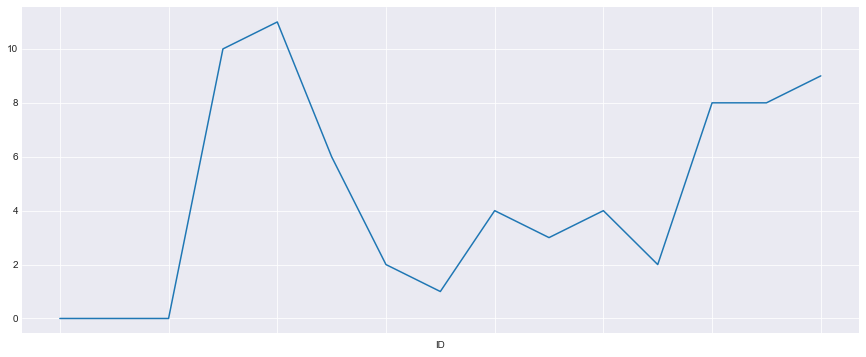

In [18]:
overclasses.plot()
overclasses

ID
iPhone XS 64         12
iPhone XS 256        10
iPhone XS 512         3
Galaxy Note 9 128     0
Galaxy note 9 512     0
Galaxy Note 8         5
Pixel 3 64            8
Pixel 3 128          10
Moto Z3               5
Galaxy s10e 128       6
Galaxy s10e 256       4
Galaxy s10 128        4
Galaxy s10 512        1
Galaxy M10 16         0
Galaxy M10 32         0
dtype: int64

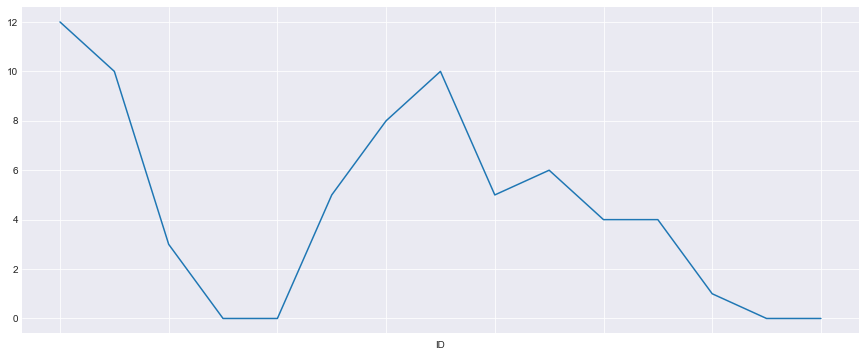

In [19]:
is_overclassed_by.plot()
is_overclassed_by